<a href="https://colab.research.google.com/github/slunara/car_damage_detector/blob/main/models/densenet121_car_damage_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car damage classifier

Densenet121 pre trained model is used to classify where the image contain the damaged car or not.

In [2]:
#import necessary librabry
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Download data

Two datasets are used

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anujms/car-damage-detection")

print("Path to dataset files:", path)

100%|██████████| 123M/123M [00:06<00:00, 18.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1


In [4]:
import os

# Define the dataset path
dataset_path = "/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a"

# List files and folders
os.listdir(dataset_path)

['training', 'validation']

In [5]:
#defining the base, train and validation directory path
base_dir = "/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a"
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
#defining the damage and whole , train and validation directory
train_damage_dir = os.path.join(train_dir, '00-damage')
train_whole_dir = os.path.join(train_dir, '01-whole')
validation_damage_dir = os.path.join(validation_dir, '00-damage')
validation_whole_dir = os.path.join(validation_dir, '01-whole')

## Preprocess the data

Data Augmentation is used to:
1. Rescale the data
2. to bring all the image to same dimension  i.e. 150x150


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


## Fine tune EfficientNetV2S

For training 1840 images are used.
For Validation 460 image are used.

Training and evaluating the model with binary crossentropy loss, accuracy, precision , recall

In [9]:
# Import necessary modules
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetV2S  # EfficientNetV2 Small
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

# Load EfficientNetV2 base model (without top layers)
base_model = EfficientNetV2S(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

# Freeze the base model layers to prevent training in the first few epochs
base_model.trainable = False  # Set to True if fine-tuning later

# Add custom layers on top of EfficientNetV2
x = GlobalAveragePooling2D()(base_model.output)  # Better than Flatten for EfficientNet
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)  # Helps prevent overfitting
x = Dense(1, activation="sigmoid")(x)  # Binary classification

# Define final model
model = Model(base_model.input, x)

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=["accuracy", "Precision", "Recall"])

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=2)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 - 72s - 777ms/step - Precision: 0.5599 - Recall: 0.6196 - accuracy: 0.5663 - loss: 0.6775 - val_Precision: 0.7228 - val_Recall: 0.3174 - val_accuracy: 0.5978 - val_loss: 0.6663
Epoch 2/50
92/92 - 6s - 68ms/step - Precision: 0.6043 - Recall: 0.6391 - accuracy: 0.6103 - loss: 0.6563 - val_Precision: 0.6131 - val_Recall: 0.8130 - val_accuracy: 0.6500 - val_loss: 0.6383
Epoch 3/50
92/92 - 8s - 87ms/step - Precision: 0.6247 - Recall: 0.6696 - accuracy: 0.6337 - loss: 0.6464 - val_Precision: 0.6357 - val_Recall: 0.7739 - val_accuracy: 0.6652 - val_loss: 0.6279
Epoch 4/50
92/92 - 7s - 74ms/step - Precision: 0.6360 - Recall: 0.6761 - accuracy: 0.6446 - loss: 0.6354 - val_Precision: 0.7011 - val_Recall: 0.5609 - val_accuracy: 0.6609 - val_loss: 0.6192
Epoch 5/50
92/92 - 6s - 63ms/step - Precision: 0.6345 - Recall: 0.6641 - accuracy: 0.6408 - loss: 0.6273 - val_Precision: 0.6615 - val_Recall: 0.7391 - val_accuracy: 0.6804 - val_loss: 0.6112
Epoch 6/50
92/92 - 7s - 81ms/step - Precision: 0.

In [10]:
#weights saving
model.save("classifier.keras")

## Results

plotting the history of train and validation loss, accurcy, precision, recall

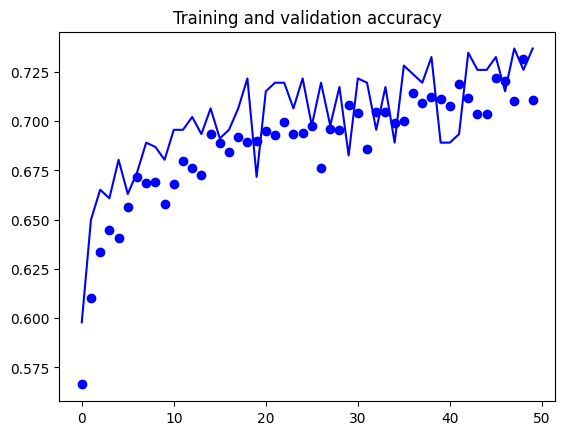

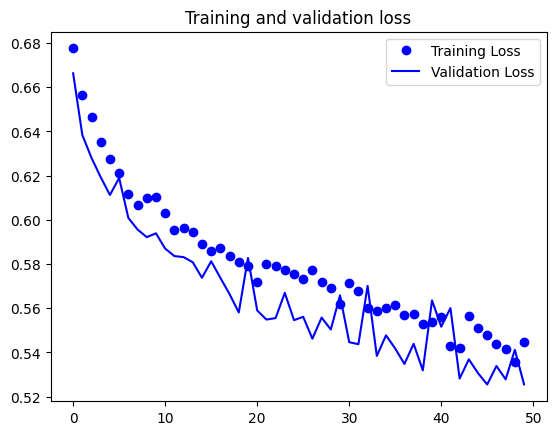

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

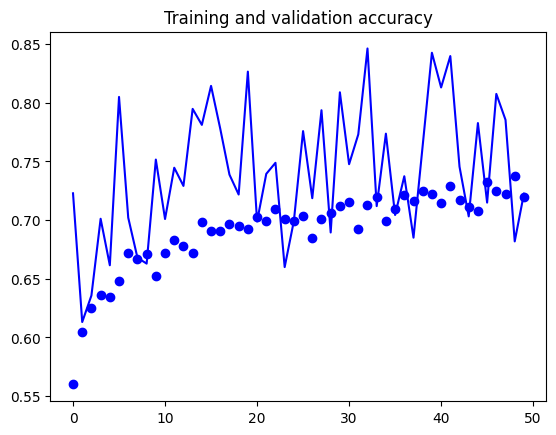

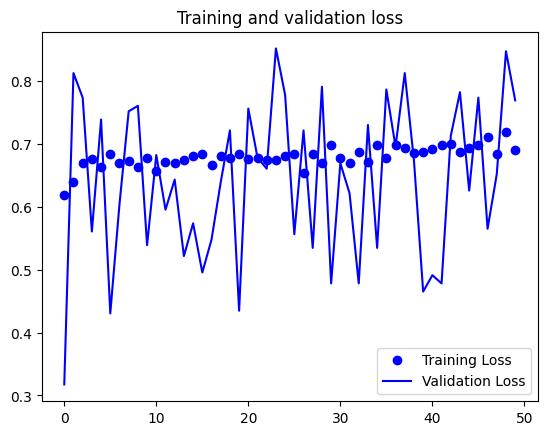

In [15]:
import matplotlib.pyplot as plt
acc = history.history['Precision']
val_acc = history.history['val_Precision']
loss = history.history['Recall']
val_loss = history.history['val_Recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
The car is damaged


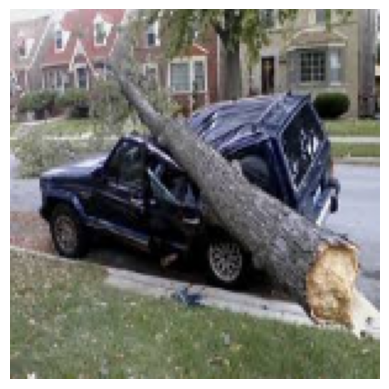

In [16]:
import cv2
im = cv2.imread("/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a/validation/00-damage/0001.JPEG")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
if pred[0][0]>0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.9395334]]
The car is damaged


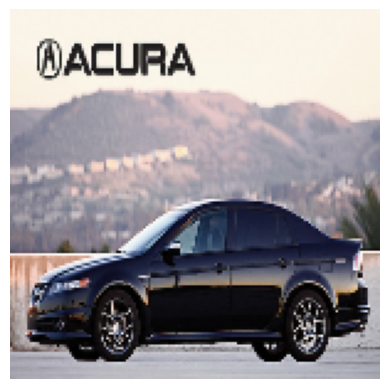

In [17]:
im = cv2.imread("/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a/validation/01-whole/0006.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
print(pred)
if pred[0][0]>0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)


Conclusion: Successfully build a classifier to classify the images containing into damage and undamage cars.

# Inference - SURA data

In [18]:
# Clone the GitHub repo
repo_url = "https://github.com/slunara/car_damage_detector.git"
!git clone {repo_url}

test_data_dir = "car_damage_detector/test_data"

assert os.path.exists(test_data_dir), "Test data folder not found!"
print("Test data downloaded successfully!")

Cloning into 'car_damage_detector'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 189 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (189/189), 13.06 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Test data downloaded successfully!


In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Define image size
IMG_SIZE = (150, 150)

# Define class labels (damage = 1, whole = 0)
class_labels = {"damage": 1, "whole": 0}

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = preprocess_input(img_array)  # Normalize
    return img_array

# Function to load test images from both classes
def load_test_images(test_data_dir):
    test_images = []
    test_labels = []
    test_filenames = []

    for category in ["damage", "whole"]:  # Iterate over both classes
        folder_path = os.path.join(test_data_dir, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            test_images.append(img_array)
            test_labels.append(class_labels[category])
            test_filenames.append(img_name)

    return np.array(test_images), np.array(test_labels), test_filenames

# Load test images
X_test, y_test, filenames = load_test_images(test_data_dir)

print(f"Loaded {len(X_test)} test images!")

Loaded 151 test images!


5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
✅ Model Accuracy on Test Data: 13.91%


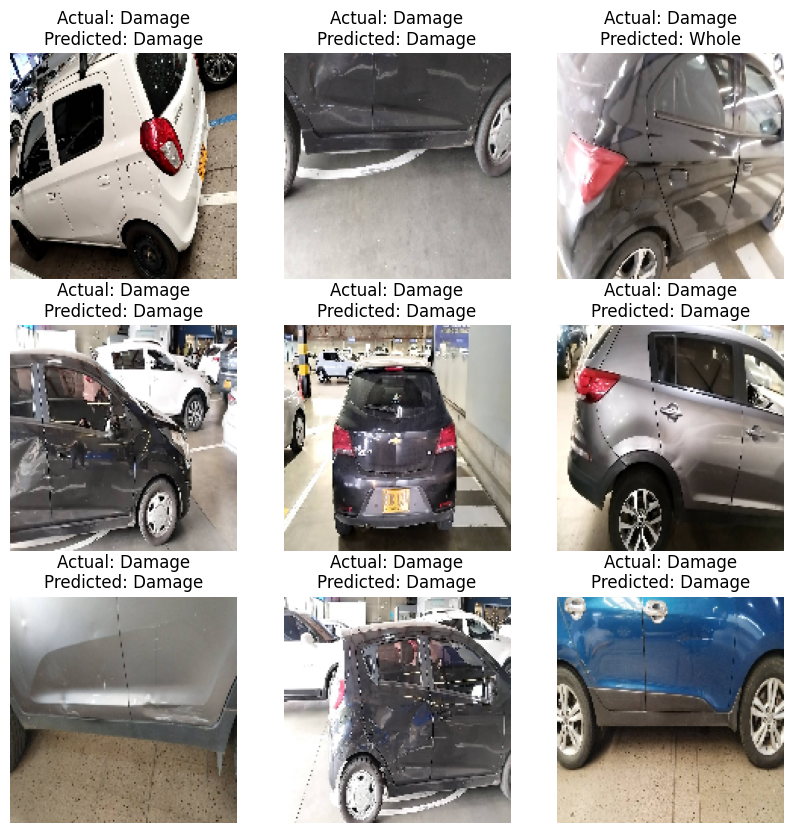

In [20]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate the model
accuracy = np.mean(y_pred_labels.flatten() == y_test)
print(f"✅ Model Accuracy on Test Data: {accuracy * 100:.2f}%")

# Show sample predictions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    img = load_img(os.path.join(test_data_dir, "damage" if y_test[i] == 1 else "whole", filenames[i]), target_size=IMG_SIZE)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Actual: {'Damage' if y_test[i] == 1 else 'Whole'}\nPredicted: {'Damage' if y_pred_labels[i] == 1 else 'Whole'}")

plt.show()

In [24]:
(y_pred, y_test)

(array([[0.89462894],
        [0.6794931 ],
        [0.45958593],
        [0.80258554],
        [0.92305446],
        [0.97466075],
        [0.60209846],
        [0.930663  ],
        [0.87728244],
        [0.930663  ],
        [0.9971527 ],
        [0.8820783 ],
        [0.6794931 ],
        [0.9839155 ],
        [0.8878761 ],
        [0.8294812 ],
        [0.9201625 ],
        [0.69255346],
        [0.98567235],
        [0.6927045 ],
        [0.59138876],
        [0.79475   ],
        [0.8882814 ],
        [0.30079457],
        [0.9586732 ],
        [0.70575726],
        [0.32553178],
        [0.886608  ],
        [0.9298695 ],
        [0.76137125],
        [0.8669759 ],
        [0.57761073],
        [0.60816854],
        [0.92916876],
        [0.8465645 ],
        [0.6339509 ],
        [0.6537327 ],
        [0.65723985],
        [0.9106135 ],
        [0.9519595 ],
        [0.9557955 ],
        [0.8971332 ],
        [0.6854107 ],
        [0.9763812 ],
        [0.96129596],
        [0